### In this example, the distribution of MNIST dataset will be learn and generate new samples form it.

In [1]:
import numpy as np
import optax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from jax.tree_util import tree_map
from torch.utils import data
from functools import partial

from utils.sampling_utils import ula, forward_OU_process, backward_OU_process
from utils.score_matching_utils import sliced_score_matching_loss, weighted_denoising_score_matching_with_ou_process_loss
from model.model import Score_MLP

### Get the dataset

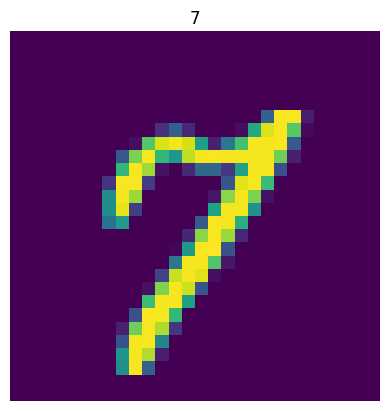

In [2]:
def visual_image(image, label=None):
    plt.figure()
    plt.imshow(image.reshape(28,28))
    if label:
        plt.title(label)
    plt.axis("off")

def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndNormal(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32)) / 255
  
mnist_dataset = MNIST('./dataset', download=True, transform=FlattenAndNormal())
training_dataloader = NumpyLoader(mnist_dataset, batch_size=128, shuffle=True, drop_last=True)

images, labels = next(iter(training_dataloader))
visual_image(images[0], labels[0])
img_dim = images.shape[1]

### Learn the MNIST distribution

In [3]:
random_key = jax.random.PRNGKey(0)
model = Score_MLP(features=[128]*4, dim=img_dim)
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, images[0], 0)
optimizer = optax.adam(learning_rate=1e-3)
optimizer_state = optimizer.init(model_param)

score_matching_loss_wrapped = partial(sliced_score_matching_loss, model.apply)

In [4]:
@jax.jit
def params_update(param, optimizer_state, xs, random_key):
    ts = jnp.zeros(xs.shape[0])
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, xs, ts, random_key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for epoch in range(200):
    total_loss = 0
    # get a batch of data
    for i, (images, labels) in enumerate(training_dataloader):
    # one step grad update
        random_key, key_to_use = jax.random.split(random_key)
        loss, model_param, optimizer_state = params_update(model_param, optimizer_state, images, key_to_use)
        total_loss += loss
    
    losses.append(total_loss / len(training_dataloader))
    print(f"iter:{epoch+1}, loss:{losses[-1]}")

iter:1, loss:-2939.120361328125
iter:2, loss:-57591.43359375
iter:3, loss:-281748.53125
iter:4, loss:-797468.9375
iter:5, loss:-1484161.125
iter:6, loss:-2788621.25
iter:7, loss:-4548871.0
iter:8, loss:-6666360.5
iter:9, loss:-10370319.0
iter:10, loss:-13664795.0
iter:11, loss:-18216052.0
iter:12, loss:-21145572.0
iter:13, loss:-26910758.0
iter:14, loss:-26299942.0
iter:15, loss:-31127538.0
iter:16, loss:-22556780.0
iter:17, loss:-40720828.0
iter:18, loss:-47277316.0
iter:19, loss:-57905852.0
iter:20, loss:-46734272.0
iter:21, loss:-86238320.0
iter:22, loss:-70987584.0
iter:23, loss:-111230712.0
iter:24, loss:-84475576.0
iter:25, loss:-113323168.0
iter:26, loss:-142587632.0
iter:27, loss:-159707968.0
iter:28, loss:-162303984.0
iter:29, loss:-158855824.0
iter:30, loss:-116068008.0
iter:31, loss:-164552000.0
iter:32, loss:-170021600.0
iter:33, loss:-221010288.0
iter:34, loss:-282433696.0
iter:35, loss:-273920768.0
iter:36, loss:-257546000.0
iter:37, loss:-277847840.0
iter:38, loss:-24346

[]

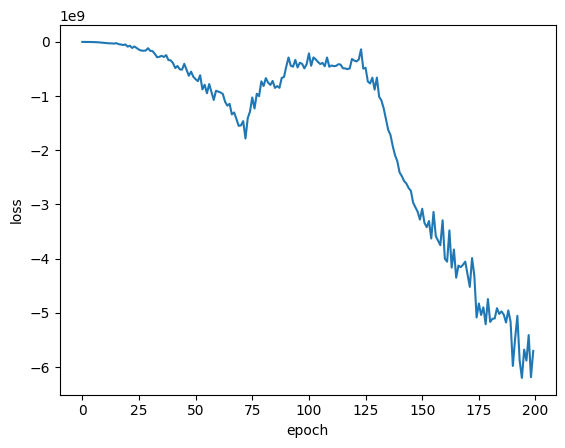

In [5]:
plt.figure()
plt.plot(losses, label="training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

### Evaluate numerical stability
The score-matching loss tend to be very big numerically.
Here we try to evaluate the numerical value of **(model param) gradient**,and the **score value** in and out of distributions   

Here, we see simply run score-matching and Langevin dynamics lead to a very **big numerical value** for score even inside distribition. Moreover, after one-step Langevin dynamics, the update result is not a valid image anymore and the score function there is **very very big**, further drift the sample away.

We also going to estimate the Lipschitz constant L of the learned function. Theoretically, for a alpha-LSI target distribution, we should choose the step size for ULA to be smaller than alpha / 4L**2. Note the alpha here can also be very large

In [6]:
# Numerical stability
loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(model_param, images, np.zeros(images.shape[0]), random_key)

for layer in grad["params"]:

    kernel_max = jnp.max(jnp.abs(grad["params"][layer]["kernel"]))
    bias_max = jnp.max(jnp.abs(grad["params"][layer]["bias"]))
    print(f"Layer:{layer}, Kernel max:{kernel_max}, Bias max:{bias_max}")

print(f"Max score inside dist:{jnp.max(jnp.abs(model.apply(model_param, images[0], 0)))}")
images_after_one_step_LD = model.apply(model_param, images[0], 0) * 0.01 + images[0]
print(f"Image max-min after one step Langevin dynamics {np.max(images_after_one_step_LD)}, {np.min(images_after_one_step_LD)}" )
print(f"Max score out dist(use one step update image):{jnp.max(jnp.abs(model.apply(model_param, images_after_one_step_LD, 0)))}")

@jax.jit
def learned_score_function_smooth_anaysis(x, y):
    return jnp.linalg.norm(model.apply(model_param, x, 0) - model.apply(model_param, y, 0)) - jnp.linalg.norm(x-y)

L = 0
for i in range(100):
    random_two_image = images[np.random.choice(images.shape[0],size=2),:]
    L_candidate = learned_score_function_smooth_anaysis(random_two_image[0], random_two_image[1])
    if L < L_candidate:
        L = L_candidate

print("Estimate L-smooth of learned score is:", L)

Layer:Dense_0, Kernel max:6322300416.0, Bias max:3525697536.0
Layer:Dense_1, Kernel max:1238018816.0, Bias max:506809376.0
Layer:Dense_2, Kernel max:136141712.0, Bias max:29459346.0
Layer:Dense_3, Kernel max:462465408.0, Bias max:4588401.0
Layer:Dense_4, Kernel max:2687103.25, Bias max:3848.631591796875
Max score inside dist:13851.4521484375
Image max-min after one step Langevin dynamics 133.3454132080078, -138.51451110839844
Max score out dist(use one step update image):120108728320.0
Estimate L-smooth of learned score is: 246982.45


Neural network prefer to learn function that do not have quick change in the magnitude. 

If function we try to approximate is nonsmooth, i.e. function value change dramatically as the input change slightly, the numerical value of neural network weight will also be pretty big, cause instability and gradient explore up in practice.

Previously, we see learn score function for the original function can be quite nonsmooth in x. Here, we also want to evaluate how the norm of score function envolve along OU process, which will be used in the diffusion process.


Suppose we learn the score function of origin image $s_\theta(x, 0)$, then along OU process, the distribution will close to standard Gaussian, with the score roughly $s(x, 0) \approx -x$.
Seems for this problem, when $t = 5$, the distribution is alreay close to standard Gaussian.
So we can random draw a image x, compute its learned norm of learn score at time zero, and estimate the score at time=1 with same image as $\|x\|$

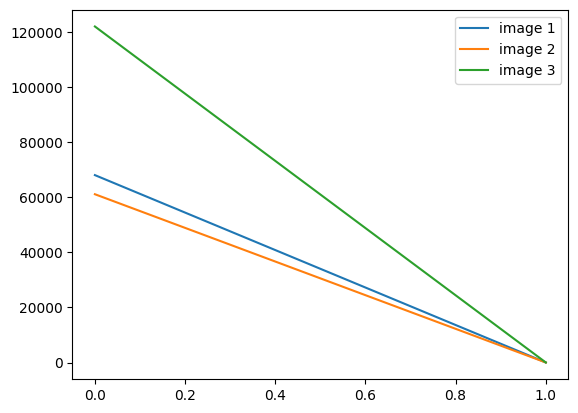

In [7]:
image_0 = images[0]
image_1 = images[1]
image_2 = images[2]
plt.figure()
plt.plot([0,5], [np.linalg.norm(model.apply(model_param, image_0, 0)), np.linalg.norm(image_0)], label="image 1")
plt.plot([0,5], [np.linalg.norm(model.apply(model_param, image_1, 0)), np.linalg.norm(image_1)], label="image 2")
plt.plot([0,5], [np.linalg.norm(model.apply(model_param, image_2, 0)), np.linalg.norm(image_2)], label="image 3")
plt.legend()
plt.show()

### Generate sample use learned score function

The initial score function biggest entries 7964.7188


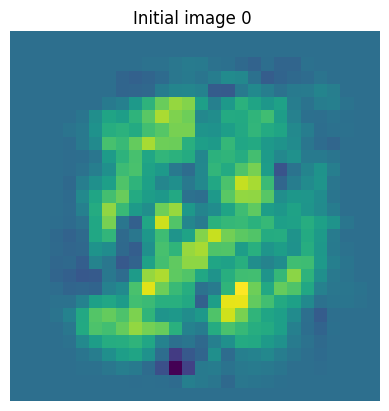

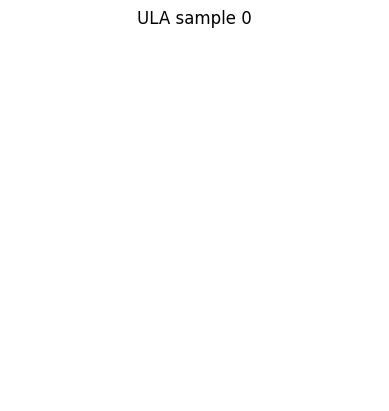

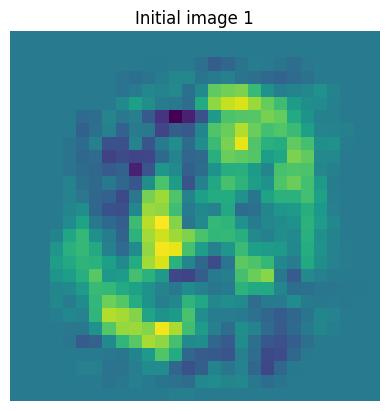

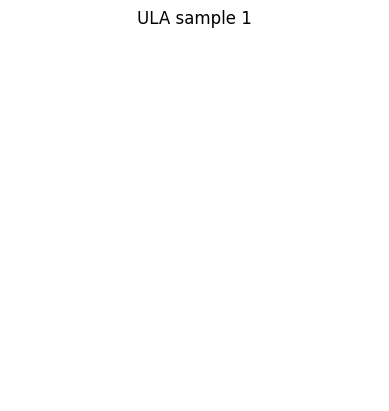

In [8]:
@jax.jit
def learned_score_fn(x, t):
    return model.apply(model_param, x, jnp.zeros_like(t))

random_key = jax.random.PRNGKey(0)

# use mean and cov calculate from samples to construct a Gaussian
x0s = np.random.multivariate_normal(mean=np.mean(images,axis=0), cov=np.cov(images, rowvar=False), size=2)
random_keys = jax.random.split(random_key, 2)

ula_wrapped = partial(ula, learned_score_fn, T=1, dt=0.01)

samples = jax.vmap(ula_wrapped)(x0s, random_keys)

print("The initial score function biggest entries", np.max(np.abs(learned_score_fn(x0s, np.array([0,0])))))

visual_image(x0s[0], label="Initial image 0 ")
visual_image(samples[0], label="ULA sample 0")
visual_image(x0s[1], label="Initial image 1")
visual_image(samples[1], label="ULA sample 1")

### Train diffusion model on MNIST

In [14]:
random_key = jax.random.PRNGKey(0)
model = Score_MLP(features=[128]*5, dim=img_dim)
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, images[0], 0)
optimizer = optax.adam(learning_rate=1e-4)
optimizer_state = optimizer.init(model_param)

score_matching_loss_wrapped = partial(sliced_score_matching_loss, model.apply)
forward_OU_process_vmap = jax.jit(jax.vmap(forward_OU_process))

# Time for forward OU process to run
T = 5
T_min = 0.01

@jax.jit
def params_update(param, optimizer_state, xs, ts, random_key):
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, xs, ts, random_key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for epoch in range(200):
    total_loss = 0
    for i, (images, labels) in enumerate(training_dataloader):
        # get a batch of data
        ts = np.random.uniform(T_min, T, size=images.shape[0])
        random_key, key_to_use = jax.random.split(random_key)
        keys_to_use = jax.random.split(key_to_use, images.shape[0])
        noisy_images = forward_OU_process_vmap(images, ts, keys_to_use)
        # one step grad update
        loss, model_param, optimizer_state = params_update(model_param, optimizer_state, noisy_images, ts, key_to_use)
        total_loss += loss
    
    losses.append(total_loss / len(training_dataloader))
    print(f"iter:{epoch+1}, loss:{losses[-1]}")

iter:1, loss:20.647523880004883
iter:2, loss:-4.650880336761475
iter:3, loss:-12.665861129760742
iter:4, loss:-17.835994720458984
iter:5, loss:-21.554973602294922
iter:6, loss:-24.410560607910156
iter:7, loss:-26.899381637573242
iter:8, loss:-28.953325271606445
iter:9, loss:-30.609609603881836
iter:10, loss:-32.12147903442383
iter:11, loss:-33.26886749267578
iter:12, loss:-34.42211151123047
iter:13, loss:-35.43977737426758
iter:14, loss:-36.1742057800293
iter:15, loss:-37.07236099243164
iter:16, loss:-37.77762985229492
iter:17, loss:-38.483394622802734
iter:18, loss:-39.171791076660156
iter:19, loss:-39.74002456665039
iter:20, loss:-40.47597885131836
iter:21, loss:-41.12092971801758
iter:22, loss:-41.805694580078125
iter:23, loss:-42.283756256103516
iter:24, loss:-42.87449264526367
iter:25, loss:-43.37343215942383
iter:26, loss:-43.76494216918945
iter:27, loss:-44.08432388305664
iter:28, loss:-44.592315673828125
iter:29, loss:-44.96366882324219
iter:30, loss:-45.30679702758789
iter:31,

[]

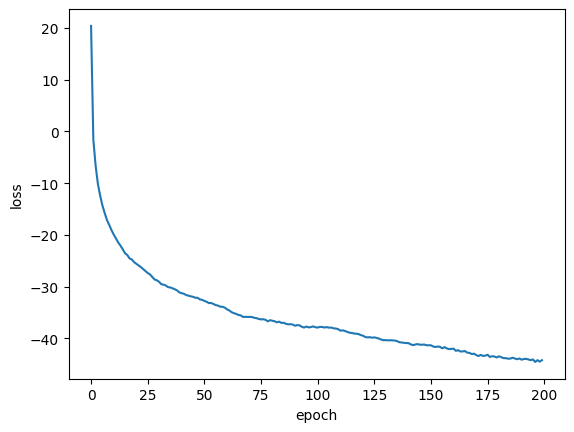

In [10]:
plt.figure()
plt.plot(losses, label="training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

### Visualize the image from forward OU process

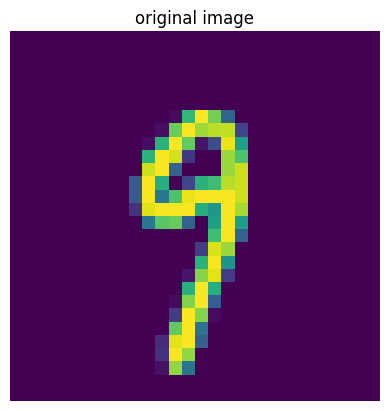

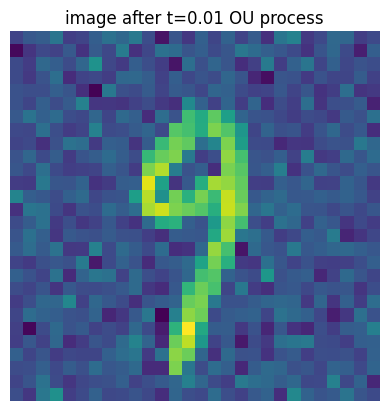

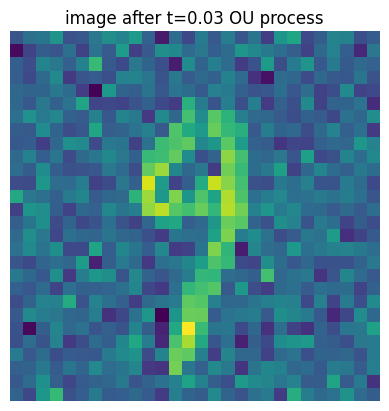

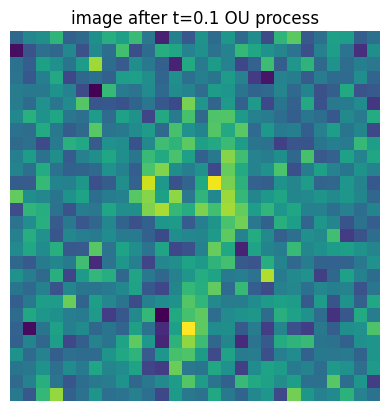

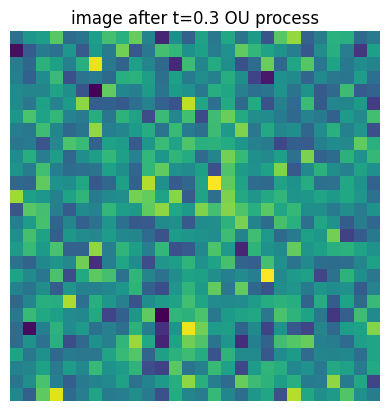

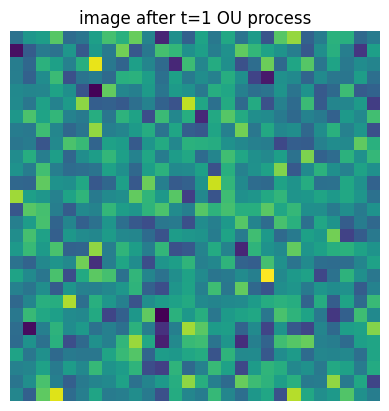

In [11]:
image = images[0]
visual_image(image, "original image")
noisy_image_001 = forward_OU_process(image, 0.01, random_key)
visual_image(noisy_image_001, "image after t=0.01 OU process")
noisy_image_003 = forward_OU_process(image, 0.03, random_key)
visual_image(noisy_image_003, "image after t=0.03 OU process")
noisy_image_01 = forward_OU_process(image, 0.1, random_key)
visual_image(noisy_image_01, "image after t=0.1 OU process")
noisy_image_03 = forward_OU_process(image, 0.3, random_key)
visual_image(noisy_image_03, "image after t=0.3 OU process")
noisy_image_1 = forward_OU_process(image, 1, random_key)
visual_image(noisy_image_1, "image after t=1 OU process")


### Sample from diffusion model on MNIST

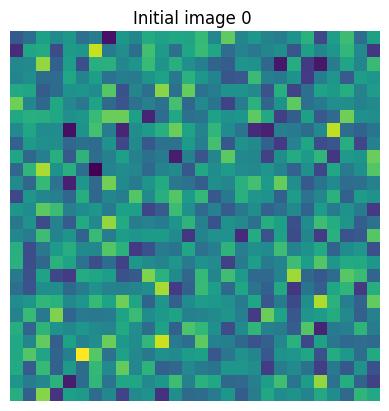

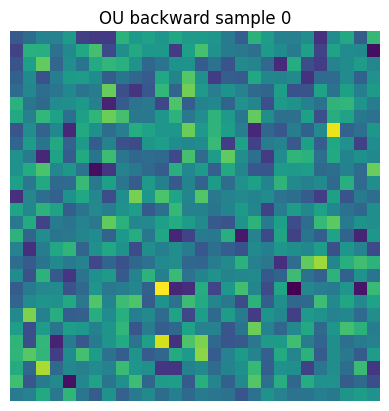

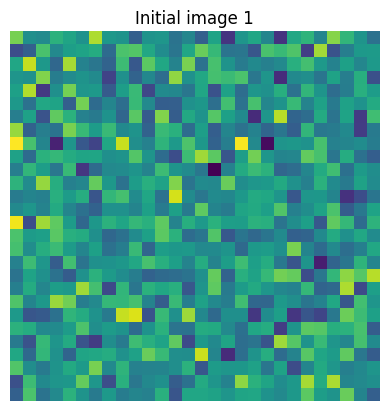

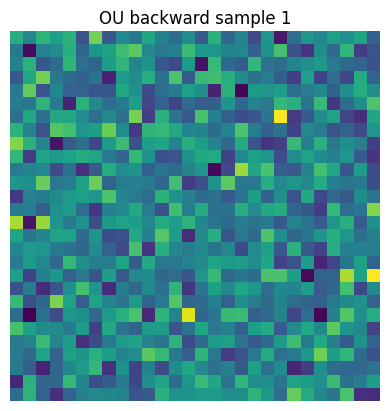

In [21]:
@jax.jit
def learned_score_fn(x, t):
    return model.apply(model_param, x, t)

random_key = jax.random.PRNGKey(0)
x0s = np.random.multivariate_normal(mean=np.zeros(img_dim), cov=np.eye(img_dim), size=2)
random_keys = jax.random.split(random_key, 2)

backward_OU_process_wrapped = partial(backward_OU_process, learned_score_fn, T=T, dt=1e-3, t0=T_min)

samples = jax.vmap(backward_OU_process_wrapped)(x0s, random_keys)

visual_image(x0s[0], label="Initial image 0 ")
visual_image(samples[0], label="OU backward sample 0")
visual_image(x0s[1], label="Initial image 1")
visual_image(samples[1], label="OU backward sample 1")


Try to get sense what's the magnitude of Fisher information, when we apply t=0.01 OU process 

In [20]:
model_param_ou_001 = model.init(key_to_use, images[0], 0)
optimizer_ou_001 = optax.adam(learning_rate=1e-4)
optimizer_state_001 = optimizer_ou_001.init(model_param)

@jax.jit
def params_update_ou001(param, optimizer_state, xs, ts, random_key):
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, xs, ts, random_key)
    update, optimizer_state = optimizer_ou_001.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for epoch in range(200):
    total_loss = 0
    for i, (images, labels) in enumerate(training_dataloader):
        # get a batch of data
        ts = np.ones(images.shape[0]) * 0.01
        random_key, key_to_use = jax.random.split(random_key)
        keys_to_use = jax.random.split(key_to_use, images.shape[0])
        noisy_images = forward_OU_process_vmap(images, ts, keys_to_use)
        # one step grad update
        loss, model_param_ou_001, optimizer_state_001 = params_update_ou001(model_param_ou_001, optimizer_state_001, noisy_images, ts, key_to_use)
        total_loss += loss
    
    losses.append(total_loss / len(training_dataloader))
    print(f"iter:{epoch+1}, loss:{losses[-1]}")

iter:1, loss:15.901561737060547
iter:2, loss:-150.68333435058594
iter:3, loss:-281.67596435546875
iter:4, loss:-358.8275451660156
iter:5, loss:-416.4938049316406
iter:6, loss:-466.9982604980469
iter:7, loss:-507.5984802246094
iter:8, loss:-546.316162109375
iter:9, loss:-581.5735473632812
iter:10, loss:-612.4798583984375
iter:11, loss:-637.3553466796875
iter:12, loss:-666.2091064453125
iter:13, loss:-693.7843627929688
iter:14, loss:-714.0850219726562
iter:15, loss:-739.7190551757812
iter:16, loss:-758.4947509765625
iter:17, loss:-784.6304321289062
iter:18, loss:-802.5922241210938
iter:19, loss:-826.7923583984375
iter:20, loss:-847.5574951171875
iter:21, loss:-870.2434692382812
iter:22, loss:-888.4046020507812
iter:23, loss:-912.3951416015625
iter:24, loss:-930.4306640625
iter:25, loss:-947.1917114257812
iter:26, loss:-966.4785766601562
iter:27, loss:-982.5731201171875
iter:28, loss:-999.974853515625
iter:29, loss:-1013.1061401367188
iter:30, loss:-1029.191162109375
iter:31, loss:-1041.4

[]

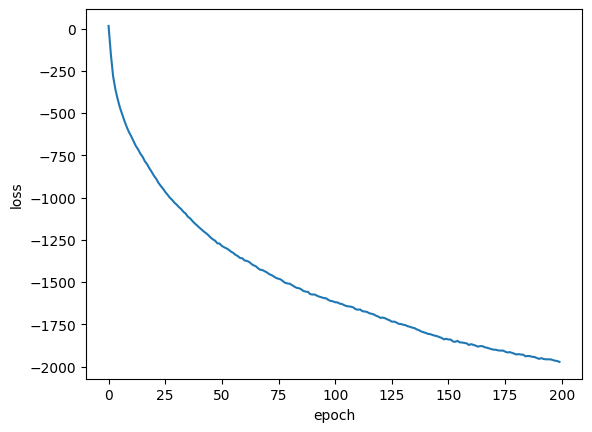

In [24]:
@jax.jit
def learned_score_fn_ou001(x):
    return model.apply(model_param_ou_001, x, 0.01)
plt.figure()
plt.plot(losses, label="training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

Similar to previous, here we test how nonsmooth of $\rho_t$ in the t direction

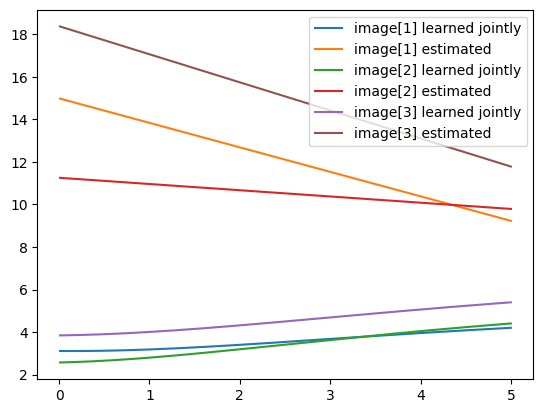

In [23]:
ts = np.arange(T_min, T, 1e-3)
plt.figure()
test_image = np.copy(images[:3])
score_norms_list = []
for (i, image) in enumerate(test_image):
    score_norms = []
    for t in ts:
        score_norms.append(np.linalg.norm(learned_score_fn(image, t)))
    score_norms_list = []
    plt.plot(ts, score_norms, label=f"image[{i+1}] learned jointly")
    plt.plot([0.01, 5], [np.linalg.norm(learned_score_fn_ou001(image)), np.linalg.norm(image)], label=f"image[{i+1}] estimated")
plt.legend()
plt.show()

### Train diffusion model with weighted denoising score matching objective

We see the original score can have very different scale based on t (or really $\rho_t$), and the output of neural network can be very large.

Here, we apply normalized denoisy score matching objective to solve this issue.

The paper can be quite good reference
    https://arxiv.org/pdf/2209.11215


In [3]:
random_key = jax.random.PRNGKey(0)

# Note here the neural model output \sqrt{1-\exp{(-2t)}} s_t(X_t) instead of the score
model = Score_MLP(features=[128]*5, dim=img_dim)
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, images[0], 0)
optimizer = optax.adam(learning_rate=1e-4)
optimizer_state = optimizer.init(model_param)

score_matching_loss_wrapped = partial(weighted_denoising_score_matching_with_ou_process_loss, model.apply)

# Time for forward OU process to run
T = 5
T_min = 0.01

@jax.jit
def params_update(param, optimizer_state, x0s, ts, random_key):
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, x0s, ts, random_key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for epoch in range(200):
    total_loss = 0
    for i, (images, labels) in enumerate(training_dataloader):
        ts = np.random.uniform(T_min, T, size=images.shape[0])
        random_key, key_to_use = jax.random.split(random_key)
        # one step grad update
        loss, model_param, optimizer_state = params_update(model_param, optimizer_state, images, ts, key_to_use)
        total_loss += loss
    
    losses.append(total_loss / len(training_dataloader))
    print(f"iter:{epoch+1}, loss:{losses[-1]}")

iter:1, loss:825.7955322265625
iter:2, loss:777.0252685546875
iter:3, loss:760.9290771484375
iter:4, loss:746.6072387695312
iter:5, loss:736.748291015625
iter:6, loss:729.718994140625
iter:7, loss:724.1730346679688
iter:8, loss:719.6453247070312
iter:9, loss:715.7296142578125
iter:10, loss:712.46142578125
iter:11, loss:709.774169921875
iter:12, loss:707.6405639648438
iter:13, loss:705.8540649414062
iter:14, loss:704.1939697265625
iter:15, loss:702.7999877929688
iter:16, loss:701.6599731445312
iter:17, loss:700.35107421875
iter:18, loss:699.6721801757812
iter:19, loss:698.740478515625
iter:20, loss:697.8455200195312
iter:21, loss:696.97998046875
iter:22, loss:696.2250366210938
iter:23, loss:695.5946655273438
iter:24, loss:694.849853515625
iter:25, loss:694.174560546875
iter:26, loss:693.3986206054688
iter:27, loss:692.9346923828125
iter:28, loss:692.3499145507812
iter:29, loss:692.302490234375
iter:30, loss:691.4677734375
iter:31, loss:691.4630126953125
iter:32, loss:690.9636840820312
i

[]

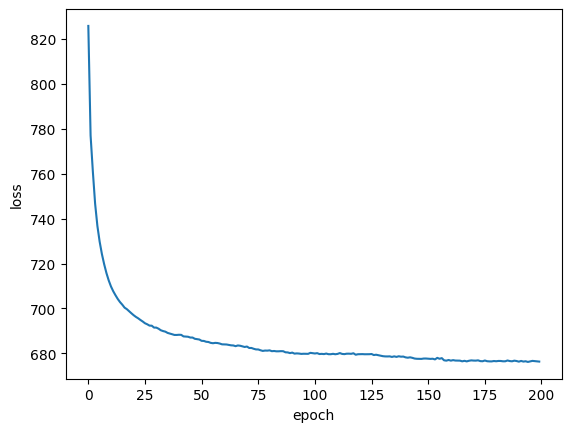

In [4]:
plt.figure()
plt.plot(losses, label="training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

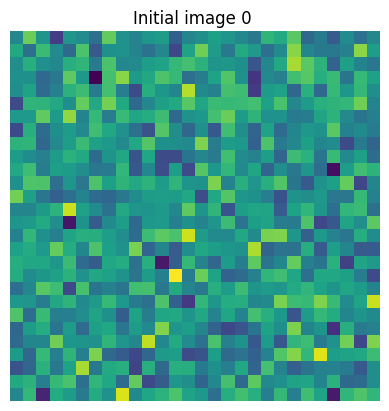

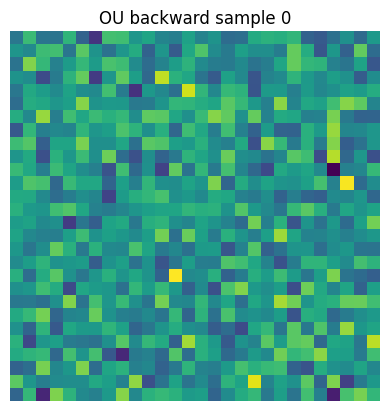

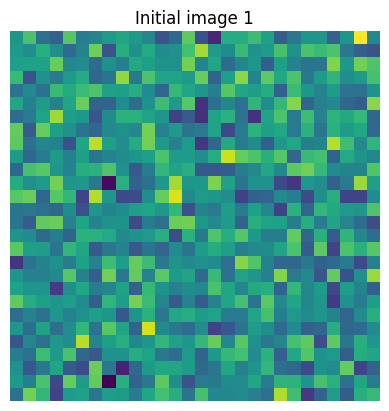

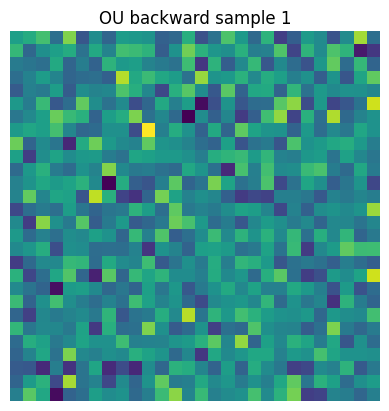

In [5]:
@jax.jit
def learned_score_fn(x, t):
    return model.apply(model_param, x, t) / (1-jnp.exp(-2*t))**0.5

random_key = jax.random.PRNGKey(0)
x0s = np.random.multivariate_normal(mean=np.zeros(img_dim), cov=np.eye(img_dim), size=2)
random_keys = jax.random.split(random_key, 2)

backward_OU_process_wrapped = partial(backward_OU_process, learned_score_fn, T=T, dt=1e-3, t0=T_min)

samples = jax.vmap(backward_OU_process_wrapped)(x0s, random_keys)

visual_image(x0s[0], label="Initial image 0 ")
visual_image(samples[0], label="OU backward sample 0")
visual_image(x0s[1], label="Initial image 1")
visual_image(samples[1], label="OU backward sample 1")